Data Preprocessing

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os

print(os.cpu_count())

96


In [3]:
!pip install netCDF4 h5netcdf xarray

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.4 MB/s eta 0:00:00


In [4]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/dataset-carbon-rep-monthly_multi-vars_179.88W-179.88E_88.12S-89.88N_2011-09-01-2022-12-01.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
ocs_df = xr_dataset.to_dataframe().reset_index()

In [5]:
import pandas as pd
ph = ocs_df[['ph', 'latitude', 'longitude', 'time']]
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [6]:
ph['yr'] = ph['time'].dt.year
ph['mn'] = ph['time'].dt.month
ph['month'] = (ph['yr'] - 2011) * 12 + ph['mn'] - 9
ph['longitude'] = (ph['longitude'] + 360) % 360
ph.drop(columns=['yr', 'mn'], inplace=True)

<ipython-input-6-a394477446e1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph['yr'] = ph['time'].dt.year
<ipython-input-6-a394477446e1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ph['mn'] = ph['time'].dt.month
<ipython-input-6-a394477446e1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

In [7]:
print(ph.shape)
print(satellite_data.shape)

(139633920, 5)
(155520000, 10)


In [8]:
ph = ph.dropna()
satellite_data = satellite_data.dropna()

In [9]:
print(ph.shape)
print(satellite_data.shape)

(79617884, 5)
(66907461, 10)


In [10]:
# when merging, remember that longitude ranges from 0-360 instead of smth else
merged_ph_df = pd.merge(ph, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [11]:
import numpy as np
merged_ph_df['mn'] = merged_ph_df['month'] % 12
merged_ph_df['cmon'] = np.cos(np.deg2rad(merged_ph_df['mn']))
merged_ph_df['smon'] = np.sin(np.deg2rad(merged_ph_df['mn']))
merged_ph_df['clon'] = np.cos(np.deg2rad(merged_ph_df['longitude']))
merged_ph_df['slon'] = np.sin(np.deg2rad(merged_ph_df['longitude']))
merged_ph_df['pic/poc'] = merged_ph_df['pic']/merged_ph_df['poc']
merged_ph_df['logchla'] = np.log(merged_ph_df['chlor_a'] + 1e-5)
merged_ph_df['windspeed'] = np.sqrt(merged_ph_df['u_wind'] ** 2 + merged_ph_df['v_wind'] ** 2)
merged_ph_df['winddir'] = (np.degrees(np.arctan2(merged_ph_df['u_wind'] + 1e-5, merged_ph_df['u_wind'] + 1e-5)) + 360) % 360

In [12]:
merged_ph_df

,ph,latitude,longitude,time,month,sst,chlor_a,sss,poc,pic,...,v_wind,mn,cmon,smon,clon,slon,pic/poc,logchla,windspeed,winddir
0,8.045918,-64.625,249.375,2011-09-01,0,0.440000,0.119880,33.823605,59.799805,0.000360,...,3.067366,0,1.00000,0.000000,-0.352250,-0.935906,6.020039e-06,-2.121184,10.800000,45.0
1,8.046334,-64.375,250.125,2011-09-01,0,0.375000,0.127854,33.787605,51.399902,0.000144,...,2.203864,0,1.00000,0.000000,-0.339969,-0.940437,2.801511e-06,-2.056788,10.599999,45.0
2,8.034484,-64.125,246.875,2011-09-01,0,0.235000,0.107158,33.830870,67.199710,0.000774,...,1.087096,0,1.00000,0.000000,-0.392738,-0.919650,1.151785e-05,-2.233360,10.400000,45.0
3,8.045823,-64.125,255.625,2011-09-01,0,-0.630000,0.103240,33.833477,52.199707,0.000328,...,2.037535,0,1.00000,0.000000,-0.248267,-0.968692,6.283501e-06,-2.270597,9.800000,45.0
4,8.044919,-64.125,255.875,2011-09-01,0,-0.830000,0.113233,33.840218,49.000000,0.000190,...,2.037535,0,1.00000,0.000000,-0.244038,-0.969766,3.877495e-06,-2.178218,9.800000,45.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60517952,8.045465,47.125,356.375,2022-12-01,135,13.875000,0.795078,35.295600,154.399900,0.000010,...,9.786570,3,0.99863,0.052336,0.997999,-0.063226,6.475833e-08,-0.229303,9.800001,45.0
60517953,8.040886,47.375,355.875,2022-12-01,135,13.395000,0.949561,35.298150,169.600100,0.000010,...,9.986296,3,0.99863,0.052336,0.997409,-0.071933,5.895444e-08,-0.051745,10.000001,225.0
60517954,8.037011,47.375,356.125,2022-12-01,135,13.759999,0.990445,35.302296,170.000000,0.000042,...,9.996573,3,0.99863,0.052336,0.997714,-0.067580,2.470525e-07,-0.009591,10.000000,225.0
60517955,8.033199,47.375,356.375,2022-12-01,135,13.835000,1.030679,35.301792,195.799800,0.000926,...,10.186021,3,0.99863,0.052336,0.997999,-0.063226,4.729297e-06,0.030227,10.200000,225.0


In [13]:
test = merged_ph_df[merged_ph_df['time'].dt.year >= 2021]
validation = merged_ph_df[(merged_ph_df['time'].dt.year >= 2019) & (merged_ph_df['time'].dt.year < 2021)]
merged_ph_df = merged_ph_df[merged_ph_df['time'].dt.year < 2019]

Feature Selection

In [ ]:
X = merged_ph_df[['latitude', 'longitude', 'sst', 'chlor_a', 'sss', 'poc', 'pic', 'u_wind', 'v_wind', 'cmon', 'smon', 'clon', 'slon', 'mn', 'pic/poc', 'logchla', 'windspeed', 'winddir']] # test with pic/poc, clon, slon, as well as month
y = merged_ph_df['ph']

In [ ]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 5.3 MB/s eta 0:00:00


In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Replace X and y with your actual data variables if different
# X = pd.DataFrame(...)  # Your features: Latitude, Longitude, SST, and SSS
# y = pd.Series(...)     # Your target variable: TA

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
X_train.shape

(48414365, 18)

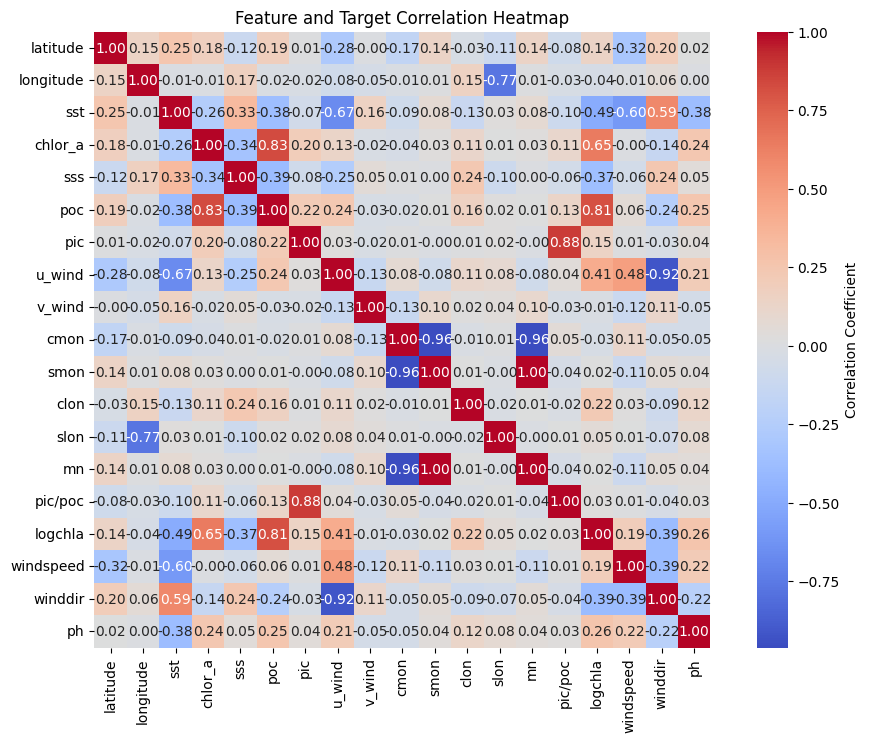

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Combine features and targets into a single DataFrame for correlation calculation
data_combined = pd.concat([X, y], axis=1)

# Calculate correlation matrix
correlation_matrix = data_combined.corr()

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True,
            cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Feature and Target Correlation Heatmap')
plt.show()

In [ ]:
correlation_matrix['ph']

,ph
latitude,0.018275
longitude,0.001768
sst,-0.383400
chlor_a,0.243624
sss,0.046832
poc,0.250618
pic,0.044610
u_wind,0.207328
v_wind,-0.051869
cmon,-0.050945


In [ ]:
sample_indices = X.sample(frac=0.05, random_state=42).index
X_sample = X.loc[sample_indices]
y_sample = y.loc[sample_indices]

# Basic Random Forest model for feature selection
rf = RandomForestRegressor(
    n_estimators=100,         # Enough trees for stable feature importance
    max_depth=15,             # Limit depth to avoid overfitting
    max_features='log2',      # Introduces randomness in splits, suitable for regression
    random_state=42,
    n_jobs=-1
)

rf.fit(X_sample, y_sample)

RandomForestRegressor(max_depth=15, max_features='log2', n_jobs=-1,
                      random_state=42)

In [ ]:
import pandas as pd

feature_importances = pd.DataFrame({
    'feature': X_sample.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)
print(feature_importances)

      feature  importance
2         sst    0.226225
0    latitude    0.193665
4         sss    0.087764
3     chlor_a    0.055255
12       slon    0.054451
1   longitude    0.054056
5         poc    0.047034
15    logchla    0.046175
11       clon    0.044074
16  windspeed    0.040841
10       smon    0.032956
13         mn    0.032637
9        cmon    0.032445
7      u_wind    0.024639
8      v_wind    0.011137
6         pic    0.007961
17    winddir    0.007911
14    pic/poc    0.000775


In [ ]:
from google.colab import runtime
runtime.unassign()

sss, latitude, clon, slon, sst, logchla

In [ ]:
X_train = merged_ph_df[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y_train = merged_ph_df['ph']
X_val = validation[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y_val = validation['ph']
X_test = test[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y_test = test['ph']

In [ ]:
!pip install xgboost joblib

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np

# Model selection and evaluation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Preprocessing and pipelines
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Regression models
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# XGBoost (make sure xgboost is installed: pip install xgboost)
import xgboost as xgb

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [ ]:
sample_indices = X_train.sample(frac=0.05, random_state=42).index
X_sample = X_train.loc[sample_indices]
y_sample = y_train.loc[sample_indices]

In [ ]:
X_sample.shape

(1962487, 8)

In [ ]:
!pip install geopandas shapely cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 96.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 2.8 MB/s eta 0:00:00


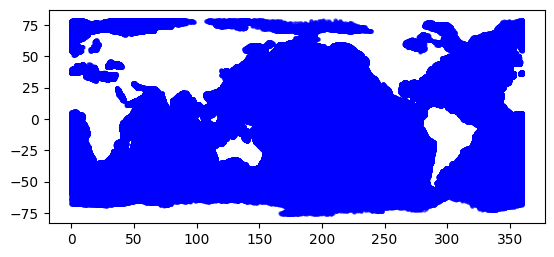

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

latitudes = X_sample['latitude']
longitudes = (np.degrees(np.arctan2(X_sample['slon'], X_sample['clon'])) + 360) % 360

gdf = gpd.GeoDataFrame(geometry=[Point(xy) for xy in zip(longitudes, latitudes)])

gdf.plot(marker='o', color='blue', markersize=5, alpha=0.5)
plt.show()

In [ ]:
!pip install tqdm

In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np

# Define the pipeline and parameter grid
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=-1, verbose=0))
])

param_grid_rf = {
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5],
    'rf__min_samples_leaf': [1, 2]
}

# Initialize variables to track the best model and score
best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_rf))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_rf.set_params(**params)

    # Perform cross-validation and get the mean score
    pipeline_rf.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_rf, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_rf, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_rf

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/24 [00:00<?, ?combination/s]

Training MSE, R2: 
5.904185207478803e-05 0.9455406891365008


Grid Search Progress:   4%|▍         | 1/24 [01:42<39:16, 102.44s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017730889505431684 0.840699831766851
Training MSE, R2: 
5.864879778364661e-05 0.945903236466493


Grid Search Progress:   8%|▊         | 2/24 [04:27<51:02, 139.19s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017678084104193079 0.8411742529344045
Training MSE, R2: 
5.988848704114993e-05 0.9447597658557981


Grid Search Progress:  12%|█▎        | 3/24 [06:02<41:41, 119.10s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017716807696850975 0.8408263473866819
Training MSE, R2: 
5.951417862968745e-05 0.9451050222700589


Grid Search Progress:  17%|█▋        | 4/24 [08:31<43:38, 130.93s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017673034765832706 0.8412196178581455
Training MSE, R2: 
6.003850942733829e-05 0.944621387477092


Grid Search Progress:  21%|██        | 5/24 [10:08<37:32, 118.55s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017735283489295689 0.8406603547643839
Training MSE, R2: 
5.968730175787336e-05 0.9449453361165217


Grid Search Progress:  25%|██▌       | 6/24 [12:37<38:41, 128.97s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017693262170010725 0.8410378881774382
Training MSE, R2: 
6.037172225117626e-05 0.9443140370109495


Grid Search Progress:  29%|██▉       | 7/24 [14:07<32:56, 116.25s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017733182957621252 0.8406792266348004
Training MSE, R2: 
6.0029673207742133e-05 0.9446295378723275


Grid Search Progress:  33%|███▎      | 8/24 [16:29<33:09, 124.37s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0001769555710332757 0.8410172697384509
Training MSE, R2: 
0.00018789810693396045 0.826685629657794


Grid Search Progress:  38%|███▊      | 9/24 [17:20<25:23, 101.55s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00027954794310081966 0.7488448938134245
Training MSE, R2: 
0.0001871565843055547 0.8273695989086487


Grid Search Progress:  42%|████▏     | 10/24 [18:41<22:14, 95.31s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00027880978734721453 0.7495080773254279
Training MSE, R2: 
0.00018790777453269096 0.8266767124110264


Grid Search Progress:  46%|████▌     | 11/24 [19:32<17:40, 81.56s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00027956354293104233 0.7488308784106545
Training MSE, R2: 
0.0001871618371809761 0.8273647537358526


Grid Search Progress:  50%|█████     | 12/24 [20:53<16:16, 81.38s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0002788180073836286 0.7495006921731869
Training MSE, R2: 
0.00018790195625166536 0.8266820791053954


Grid Search Progress:  54%|█████▍    | 13/24 [21:43<13:11, 71.92s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0002795685489445826 0.7488263808427299
Training MSE, R2: 
0.00018716311451601533 0.8273635755413425


Grid Search Progress:  58%|█████▊    | 14/24 [23:04<12:27, 74.72s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00027882176545450176 0.7494973157981768
Training MSE, R2: 
0.00018790539187158367 0.8266789101415746


Grid Search Progress:  62%|██████▎   | 15/24 [23:55<10:06, 67.43s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00027956818345867816 0.7488267092073393
Training MSE, R2: 
0.00018716567848989338 0.8273612105706385


Grid Search Progress:  67%|██████▋   | 16/24 [25:15<09:30, 71.32s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0002788209501229635 0.749498048318963
Training MSE, R2: 
6.847831454981612e-05 0.93683663895311


Grid Search Progress:  71%|███████   | 17/24 [26:31<08:29, 72.72s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00018022723819009502 0.8380778958941522
Training MSE, R2: 
6.818106685010983e-05 0.9371108157330196


Grid Search Progress:  75%|███████▌  | 18/24 [28:32<08:44, 87.38s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017984846249836985 0.8384182004874212
Training MSE, R2: 
6.89088044629871e-05 0.9364395615718774


Grid Search Progress:  79%|███████▉  | 19/24 [29:48<06:58, 83.67s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00018028276300152197 0.8380280105694553
Training MSE, R2: 
6.861869608403031e-05 0.9367071531503681


Grid Search Progress:  83%|████████▎ | 20/24 [31:45<06:15, 93.89s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017993109324645394 0.8383439622938608
Training MSE, R2: 
6.88446637522077e-05 0.9364987239928481


Grid Search Progress:  88%|████████▊ | 21/24 [33:01<04:25, 88.34s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0001803234857967117 0.8379914238650902
Training MSE, R2: 
6.855838844711837e-05 0.9367627800020101


Grid Search Progress:  92%|█████████▏| 22/24 [35:02<03:16, 98.29s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.0001799830465866023 0.8382972856969344
Training MSE, R2: 
6.901681918068934e-05 0.9363399304308737


Grid Search Progress:  96%|█████████▌| 23/24 [36:16<01:30, 90.99s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00018028451002293484 0.8380264409877098
Training MSE, R2: 
6.8746218772043e-05 0.9365895281527675


Grid Search Progress: 100%|██████████| 24/24 [38:15<00:00, 95.64s/combination, Best MSE=0.000177]

Validation MSE, R2: 
0.00017999365983392376 0.8382877504049611
Best MSE: 
0.00017673034765832706


In [ ]:
best_params = {'rf__max_depth': 20,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 5,
 'rf__n_estimators': 200}

In [ ]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42, n_jobs=67, verbose=1))
])
pipeline_rf.set_params(**best_params)
pipeline_rf.fit(X_train, y_train)
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_train, y_train)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_val, y_val)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")
mse_rf, r2_rf = evaluate_model(pipeline_rf, X_test, y_test)
print(f"rf - MSE: {mse_rf:.4f}, R²: {r2_rf:.4f}")

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed: 14.6min
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed: 32.9min finished
[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   12.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   24.9s finished


rf - MSE: 0.0001, R²: 0.9534


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.5s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.3s finished


rf - MSE: 0.0002, R²: 0.8383


[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.7s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.6s finished


rf - MSE: 0.0003, R²: 0.7458


In [ ]:
!pip install joblib

In [ ]:
import joblib
joblib.dump(pipeline_rf, '/content/drive/MyDrive/STS/rf_ph.joblib')

['/content/drive/MyDrive/STS/rf_ph.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])

param_grid_knn = {
    'knn__n_neighbors': [3, 5, 7],
    'knn__weights': ['uniform', 'distance']
}

best_score = float('-inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_knn))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_knn.set_params(**params)

    # Perform cross-validation and get the mean score
    scores = cross_val_score(pipeline_knn, X_sample, y_sample, cv=5, scoring='neg_mean_squared_error', n_jobs=1, verbose=3)
    mean_score = np.mean(scores)

    # Update the best model if the current score is better
    if mean_score > best_score:
        best_score = mean_score
        best_params = params
        best_model = pipeline_knn

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': -best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")
print(best_score)

Grid Search Progress:   0%|          | 0/6 [00:00<?, ?combination/s]

[CV] END ............................... score: (test=-0.000) total time=  37.4s
[CV] END ............................... score: (test=-0.000) total time=  38.0s
[CV] END ............................... score: (test=-0.000) total time=  32.2s
[CV] END ............................... score: (test=-0.000) total time=  32.4s


Grid Search Progress:  17%|█▋        | 1/6 [02:52<14:23, 172.64s/combination, Best MSE=0.000108]

[CV] END ............................... score: (test=-0.000) total time=  32.5s
[CV] END ............................... score: (test=-0.000) total time=  32.8s
[CV] END ............................... score: (test=-0.000) total time=  32.3s
[CV] END ............................... score: (test=-0.000) total time=  32.0s
[CV] END ............................... score: (test=-0.000) total time=  32.2s


Grid Search Progress:  33%|███▎      | 2/6 [05:38<11:13, 168.49s/combination, Best MSE=0.000105]

[CV] END ............................... score: (test=-0.000) total time=  36.2s
[CV] END ............................... score: (test=-0.000) total time=  51.5s
[CV] END ............................... score: (test=-0.000) total time=  50.8s
[CV] END ............................... score: (test=-0.000) total time=  37.2s
[CV] END ............................... score: (test=-0.000) total time=  36.6s


Grid Search Progress:  50%|█████     | 3/6 [09:18<09:36, 192.12s/combination, Best MSE=0.000103]

[CV] END ............................... score: (test=-0.000) total time=  44.0s
[CV] END ............................... score: (test=-0.000) total time=  43.7s
[CV] END ............................... score: (test=-0.000) total time=  41.6s
[CV] END ............................... score: (test=-0.000) total time=  41.9s
[CV] END ............................... score: (test=-0.000) total time=  41.1s


Grid Search Progress:  67%|██████▋   | 4/6 [12:47<06:37, 198.97s/combination, Best MSE=9.85e-5]

[CV] END ............................... score: (test=-0.000) total time=  41.1s
[CV] END ............................... score: (test=-0.000) total time=  47.1s
[CV] END ............................... score: (test=-0.000) total time=  46.9s
[CV] END ............................... score: (test=-0.000) total time=  46.6s
[CV] END ............................... score: (test=-0.000) total time=  46.0s


Grid Search Progress:  83%|████████▎ | 5/6 [16:40<03:31, 211.21s/combination, Best MSE=9.85e-5]

[CV] END ............................... score: (test=-0.000) total time=  46.2s
[CV] END ............................... score: (test=-0.000) total time=  44.7s
[CV] END ............................... score: (test=-0.000) total time=  44.5s
[CV] END ............................... score: (test=-0.000) total time=  42.7s
[CV] END ............................... score: (test=-0.000) total time=  42.6s


Grid Search Progress: 100%|██████████| 6/6 [20:14<00:00, 202.49s/combination, Best MSE=9.71e-5]

[CV] END ............................... score: (test=-0.000) total time=  39.4s
Best MSE: 
-9.710255167083657e-05


In [ ]:
best_params = {'knn__n_neighbors': 7, 'knn__weights': 'distance'}

In [ ]:
pipeline_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_jobs=-1))
])
pipeline_knn.set_params(**best_params)
pipeline_knn.fit(X_train, y_train)
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_train, y_train)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_val, y_val)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")
mse_knn, r2_knn = evaluate_model(pipeline_knn, X_test, y_test)
print(f"knn - MSE: {mse_knn:.4f}, R²: {r2_knn:.4f}")

knn - MSE: 0.0000, R²: 1.0000
knn - MSE: 0.0002, R²: 0.8093
knn - MSE: 0.0003, R²: 0.7124


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
joblib.dump(best_model, '/content/drive/MyDrive/STS/knn_ph.joblib')

In [ ]:
pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LinearRegression())
])

# Fit the model
pipeline_lr.fit(X_train, y_train)

# Evaluate
mse_lr, r2_lr = evaluate_model(pipeline_lr, X_test, y_test)
print(f"Linear Regression - MSE: {mse_lr:.4f}, R²: {r2_lr:.4f}")

Linear Regression - MSE: 0.0008, R²: 0.2635


In [ ]:
from sklearn.model_selection import ParameterGrid, cross_val_score
from tqdm import tqdm
import numpy as np
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1))
])

param_grid_xgb = {
    'xgb__n_estimators': [200],             # Number of boosting rounds
    'xgb__max_depth': [3, 6, 9],                    # Maximum depth of a tree
    'xgb__learning_rate': [0.05, 0.1],           # Step size shrinkage
    'xgb__subsample': [0.8],                # Fraction of samples for each boosting round
    'xgb__colsample_bytree': [0.8, 1.0],         # Fraction of features used per tree
    'xgb__min_child_weight': [1, 5],             # Minimum sum of instance weight for leaf nodes
    'xgb__gamma': [0, 0.1],                      # Minimum loss reduction for partitioning
}

best_score = float('inf')
best_params = None
best_model = None

# Create a parameter grid list and initialize the progress bar
param_grid_list = list(ParameterGrid(param_grid_xgb))
progress_bar = tqdm(total=len(param_grid_list), desc="Grid Search Progress", unit="combination")

# Iterate over each parameter combination
for params in param_grid_list:
    # Set the parameters for the current iteration
    pipeline_xgb.set_params(**params)

    pipeline_xgb.fit(X_sample, y_sample)
    mse, r2 = evaluate_model(pipeline_xgb, X_train, y_train)
    print('Training MSE, R2: ')
    print(mse, r2)
    mse, r2 = evaluate_model(pipeline_xgb, X_val, y_val)
    print('Validation MSE, R2: ')
    print(mse, r2)

    # Update the best model if the current score is better
    if mse < best_score:
        best_score = mse
        best_params = params
        best_model = pipeline_xgb

    # Update the progress bar and display the current best score
    progress_bar.set_postfix({'Best MSE': best_score})
    progress_bar.update(1)

# Close the progress bar after completion
progress_bar.close()
print("Best MSE: ")

Grid Search Progress:   0%|          | 0/48 [00:00<?, ?combination/s]

Training MSE, R2: 
0.00031451776 0.7098937630653381


Grid Search Progress:   2%|▏         | 1/48 [00:12<09:57, 12.71s/combination, Best MSE=0.000409]

Validation MSE, R2: 
0.00040940745 0.6321753263473511
Training MSE, R2: 
0.00031451776 0.7098937630653381


Grid Search Progress:   4%|▍         | 2/48 [00:22<08:24, 10.96s/combination, Best MSE=0.000409]

Validation MSE, R2: 
0.00040940745 0.6321753263473511
Training MSE, R2: 
0.00014847613 0.8630479574203491


Grid Search Progress:   6%|▋         | 3/48 [00:36<09:11, 12.24s/combination, Best MSE=0.000239]

Validation MSE, R2: 
0.00023884185 0.7854169011116028
Training MSE, R2: 
0.00014782336 0.8636500835418701


Grid Search Progress:   8%|▊         | 4/48 [00:50<09:30, 12.96s/combination, Best MSE=0.000238]

Validation MSE, R2: 
0.00023796053 0.7862087488174438
Training MSE, R2: 
9.490121e-05 0.9124646186828613


Grid Search Progress:  10%|█         | 5/48 [01:13<12:01, 16.78s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.00019114309 0.8282709717750549
Training MSE, R2: 
9.495482e-05 0.9124151468276978


Grid Search Progress:  12%|█▎        | 6/48 [01:35<12:50, 18.35s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.00019112007 0.828291654586792
Training MSE, R2: 
0.00024120226 0.7775188088417053


Grid Search Progress:  15%|█▍        | 7/48 [01:45<10:47, 15.80s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.0003357191 0.6983793377876282
Training MSE, R2: 
0.00024120226 0.7775188088417053


Grid Search Progress:  17%|█▋        | 8/48 [01:54<09:02, 13.57s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.0003357191 0.6983793377876282
Training MSE, R2: 
0.00012400417 0.8856204748153687


Grid Search Progress:  19%|█▉        | 9/48 [02:07<08:45, 13.47s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.00021532299 0.8065469861030579
Training MSE, R2: 
0.00012404761 0.8855804204940796


Grid Search Progress:  21%|██        | 10/48 [02:20<08:27, 13.37s/combination, Best MSE=0.000191]

Validation MSE, R2: 
0.00021501767 0.8068212866783142
Training MSE, R2: 
8.61726e-05 0.920515775680542


Grid Search Progress:  23%|██▎       | 11/48 [02:44<10:08, 16.44s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00018523392 0.833579957485199
Training MSE, R2: 
8.6310734e-05 0.9203883409500122


Grid Search Progress:  25%|██▌       | 12/48 [03:08<11:18, 18.85s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00018492439 0.833858072757721
Training MSE, R2: 
0.0003167851 0.707802414894104


Grid Search Progress:  27%|██▋       | 13/48 [03:18<09:25, 16.15s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00041350233 0.6284964084625244
Training MSE, R2: 
0.0003167851 0.707802414894104


Grid Search Progress:  29%|██▉       | 14/48 [03:28<08:04, 14.26s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00041350233 0.6284964084625244
Training MSE, R2: 
0.00017443976 0.8390995264053345


Grid Search Progress:  31%|███▏      | 15/48 [03:39<07:19, 13.33s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026361278 0.7631618976593018
Training MSE, R2: 
0.00017443976 0.8390995264053345


Grid Search Progress:  33%|███▎      | 16/48 [03:52<07:03, 13.24s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026361278 0.7631618976593018
Training MSE, R2: 
0.00013966394 0.8711761832237244


Grid Search Progress:  35%|███▌      | 17/48 [04:06<06:58, 13.51s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023109866 0.7923736572265625
Training MSE, R2: 
0.00014005697 0.8708136677742004


Grid Search Progress:  38%|███▊      | 18/48 [04:21<06:50, 13.70s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023138398 0.7921172976493835
Training MSE, R2: 
0.00024154186 0.7772055864334106


Grid Search Progress:  40%|███▉      | 19/48 [04:30<05:56, 12.30s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0003367796 0.6974265575408936
Training MSE, R2: 
0.00024154186 0.7772055864334106


Grid Search Progress:  42%|████▏     | 20/48 [04:39<05:16, 11.30s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0003367796 0.6974265575408936
Training MSE, R2: 
0.0001766715 0.8370409607887268


Grid Search Progress:  44%|████▍     | 21/48 [04:47<04:42, 10.45s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0002660608 0.7609625458717346
Training MSE, R2: 
0.0001766715 0.8370409607887268


Grid Search Progress:  46%|████▌     | 22/48 [05:00<04:53, 11.30s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0002660608 0.7609625458717346
Training MSE, R2: 
0.00014051872 0.8703877329826355


Grid Search Progress:  48%|████▊     | 23/48 [05:09<04:20, 10.41s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023296618 0.7906957864761353
Training MSE, R2: 
0.00013976509 0.8710829019546509


Grid Search Progress:  50%|█████     | 24/48 [05:17<03:56,  9.83s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023204196 0.7915261387825012
Training MSE, R2: 
0.00030394582 0.7196451425552368


Grid Search Progress:  52%|█████▏    | 25/48 [05:32<04:17, 11.21s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0003994725 0.6411012411117554
Training MSE, R2: 
0.00030394582 0.7196451425552368


Grid Search Progress:  54%|█████▍    | 26/48 [05:42<04:01, 10.99s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0003994725 0.6411012411117554
Training MSE, R2: 
0.00014920963 0.8623713850975037


Grid Search Progress:  56%|█████▋    | 27/48 [05:58<04:24, 12.59s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00024074335 0.7837085723876953
Training MSE, R2: 
0.00014860615 0.862928032875061


Grid Search Progress:  58%|█████▊    | 28/48 [06:15<04:33, 13.68s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023968615 0.7846583724021912
Training MSE, R2: 
9.499815e-05 0.9123752117156982


Grid Search Progress:  60%|██████    | 29/48 [06:36<05:04, 16.00s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00019289696 0.8266952633857727
Training MSE, R2: 
9.538037e-05 0.9120226502418518


Grid Search Progress:  62%|██████▎   | 30/48 [07:00<05:31, 18.40s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00019318105 0.8264400362968445
Training MSE, R2: 
0.00024074347 0.7779420018196106


Grid Search Progress:  65%|██████▍   | 31/48 [07:13<04:46, 16.88s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00033626342 0.6978902816772461
Training MSE, R2: 
0.00024074347 0.7779420018196106


Grid Search Progress:  67%|██████▋   | 32/48 [07:26<04:11, 15.69s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00033626342 0.6978902816772461
Training MSE, R2: 
0.00012316027 0.8863989114761353


Grid Search Progress:  69%|██████▉   | 33/48 [07:46<04:16, 17.07s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00021591972 0.8060108423233032
Training MSE, R2: 
0.00012324806 0.8863179087638855


Grid Search Progress:  71%|███████   | 34/48 [07:59<03:40, 15.76s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00021597088 0.8059648871421814
Training MSE, R2: 
8.5451335e-05 0.9211810231208801


Grid Search Progress:  73%|███████▎  | 35/48 [08:16<03:29, 16.09s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00018603867 0.8328569531440735
Training MSE, R2: 
8.539814e-05 0.9212300777435303


Grid Search Progress:  75%|███████▌  | 36/48 [08:33<03:15, 16.26s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00018595967 0.832927942276001
Training MSE, R2: 
0.00030394577 0.7196451425552368


Grid Search Progress:  77%|███████▋  | 37/48 [08:41<02:32, 13.90s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00039946736 0.6411058902740479
Training MSE, R2: 
0.00030394577 0.7196451425552368


Grid Search Progress:  79%|███████▉  | 38/48 [08:50<02:03, 12.33s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00039946736 0.6411058902740479
Training MSE, R2: 
0.00017866047 0.8352063894271851


Grid Search Progress:  81%|████████▏ | 39/48 [09:00<01:44, 11.66s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026807527 0.7591527104377747
Training MSE, R2: 
0.00017866047 0.8352063894271851


Grid Search Progress:  83%|████████▎ | 40/48 [09:09<01:27, 10.99s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026807527 0.7591527104377747
Training MSE, R2: 
0.00013820545 0.8725214600563049


Grid Search Progress:  85%|████████▌ | 41/48 [09:19<01:13, 10.56s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023144492 0.792062520980835
Training MSE, R2: 
0.00013869796 0.8720672130584717


Grid Search Progress:  88%|████████▊ | 42/48 [09:31<01:06, 11.13s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.0002316569 0.7918720841407776
Training MSE, R2: 
0.00024331655 0.7755686044692993


Grid Search Progress:  90%|████████▉ | 43/48 [09:44<00:57, 11.58s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00033965224 0.6948456764221191
Training MSE, R2: 
0.00024331655 0.7755686044692993


Grid Search Progress:  92%|█████████▏| 44/48 [09:52<00:42, 10.66s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00033965224 0.6948456764221191
Training MSE, R2: 
0.00017893378 0.8349542617797852


Grid Search Progress:  94%|█████████▍| 45/48 [10:00<00:29,  9.70s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026920735 0.7581355571746826
Training MSE, R2: 
0.00017893378 0.8349542617797852


Grid Search Progress:  96%|█████████▌| 46/48 [10:10<00:19,  9.77s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00026920735 0.7581355571746826
Training MSE, R2: 
0.00013888266 0.8718968033790588


Grid Search Progress:  98%|█████████▊| 47/48 [10:18<00:09,  9.18s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023167071 0.7918596863746643
Training MSE, R2: 
0.000139479 0.8713467717170715


Grid Search Progress: 100%|██████████| 48/48 [10:27<00:00, 13.07s/combination, Best MSE=0.000185]

Validation MSE, R2: 
0.00023233944 0.7912588715553284
Best MSE: 


In [ ]:
best_params

{'xgb__colsample_bytree': 0.8,
 'xgb__gamma': 0,
 'xgb__learning_rate': 0.1,
 'xgb__max_depth': 9,
 'xgb__min_child_weight': 5,
 'xgb__n_estimators': 200,
 'xgb__subsample': 0.8}

In [ ]:
pipeline_xgb.set_params(**best_params)
pipeline_xgb.fit(X_train, y_train)
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_train, y_train)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_val, y_val)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")
mse_xgb, r2_xgb = evaluate_model(pipeline_xgb, X_test, y_test)
print(f"XGB - MSE: {mse_xgb:.4f}, R²: {r2_xgb:.4f}")

XGB - MSE: 0.0001, R²: 0.9235
XGB - MSE: 0.0002, R²: 0.8352
XGB - MSE: 0.0003, R²: 0.7480


In [ ]:
import joblib
joblib.dump(pipeline_xgb, '/content/drive/MyDrive/STS/xgb_ph.joblib')

['/content/drive/MyDrive/STS/xgb_ph.joblib']

In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_sample = X_sample.to_numpy()
y_sample = y_sample.to_numpy()

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
import numpy as np

# Define a function to build the model with given hyperparameters
def build_model(n_hidden_layers=1, n_neurons=64, activation='relu', optimizer='adam',
                learning_rate=0.001, dropout_rate=0.0, input_shape=None):
    model = keras.Sequential()
    # Input layer
    model.add(layers.InputLayer(input_shape=input_shape))
    # Hidden layers
    for _ in range(n_hidden_layers):
        model.add(layers.Dense(n_neurons, activation=activation))
        if dropout_rate > 0.0:
            model.add(layers.Dropout(dropout_rate))
    # Output layer
    model.add(layers.Dense(1))  # Assuming regression output
    # Compile model
    if optimizer == 'adam':
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        opt = optimizer  # Handle other optimizers as needed
    model.compile(optimizer=opt, loss='mse')
    return model

params = {'activation': 'relu', 'batch_size': 64, 'dropout_rate': 0.0, 'epochs': 2, 'learning_rate': 0.001, 'n_hidden_layers': 1, 'n_neurons': 32, 'optimizer': 'adam'}
model = build_model(
    n_hidden_layers=params['n_hidden_layers'],
    n_neurons=params['n_neurons'],
    activation=params['activation'],
    optimizer=params['optimizer'],
    learning_rate=params['learning_rate'],
    dropout_rate=params['dropout_rate'],
    input_shape=(X_sample.shape[1],)
)
    # Fit the model
history = model.fit(
    X_sample, y_sample,
    epochs=params['epochs'],
    batch_size=params['batch_size'],
    verbose=1
)

Epoch 1/2
30664/30664 [==============================] - 45s 1ms/step - loss: 0.2159
Epoch 2/2
30664/30664 [==============================] - 44s 1ms/step - loss: 0.0032


In [ ]:
y_train_pred = model.predict(X_sample)
mse_train = mean_squared_error(y_sample, y_train_pred)
r2_train = r2_score(y_sample, y_train_pred)
print('Best Model Training MSE:', mse_train)
print('Best Model Training R²:', r2_train)

# Evaluate the best model on validation set
y_val_pred = model.predict(X_val)
mse_val = mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)
print('Best Model Validation MSE:', mse_val)
print('Best Model Validation R²:', r2_val)

# Evaluate the best model on test set
y_test_pred = model.predict(X_test)
mse_test = mean_squared_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)
print('Best Model Test MSE:', mse_test)
print('Best Model Test R²:', r2_test)

61328/61328 [==============================] - 68s 1ms/step
Best Model Training MSE: 0.0009517101
Best Model Training R²: 0.12284737825393677
333416/333416 [==============================] - 374s 1ms/step
Best Model Validation MSE: 0.000989514
Best Model Validation R²: 0.11098921298980713
331217/331217 [==============================] - 367s 1ms/step
Best Model Test MSE: 0.0011408069
Best Model Test R²: -0.023804068565368652


In [ ]:
from google.colab import runtime
runtime.unassign()

## In situ data

In [ ]:
import pandas as pd

glodap_df = pd.read_csv('/content/drive/MyDrive/STS/STSData/GLODAPv2.2023_Merged_Master_File.csv', dtype=str)

In [ ]:
import numpy as np
glodap_pH = glodap_df[['G2phtsinsitutp', 'G2latitude', 'G2longitude', 'G2year', 'G2month', 'G2depth']]
glodap_pH = glodap_pH.apply(pd.to_numeric, errors='raise')
glodap_pH.replace(-9999, np.nan, inplace=True)
glodap_pH = glodap_pH.dropna()
glodap_pH = glodap_pH[((glodap_pH['G2latitude'] < 30) & (glodap_pH['G2depth'] <= 20)) | ((glodap_pH['G2latitude'] >= 30) & (glodap_pH['G2depth'] <= 30))]
glodap_pH = glodap_pH[(glodap_pH['G2latitude'] <= 90) & (glodap_pH['G2latitude'] >= -90) & (glodap_pH['G2longitude'] >= -180) & (glodap_pH['G2longitude'] <= 180)]
glodap_pH = glodap_pH[(glodap_pH['G2year'] > 2011) | ((glodap_pH['G2year'] == 2011) & (glodap_pH['G2month'] > 9))]
glodap_pH['month'] = (glodap_pH['G2year'] - 2011) * 12 + glodap_pH['G2month'] - 9
glodap_pH['longitude'] = (glodap_pH['G2longitude'] + 360) % 360
glodap_pH['longitude'] = round((glodap_pH['G2longitude']) / 0.25) * 0.25 + 0.125
glodap_pH['latitude'] = round((glodap_pH['G2latitude']) / 0.25) * 0.25 + 0.125
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')
glodappHMatchup = pd.merge(glodap_pH, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
glodappHMatchup = glodappHMatchup.dropna()
glodappHMatchup['clon'] = np.cos(np.deg2rad(glodappHMatchup['longitude']))
glodappHMatchup['slon'] = np.sin(np.deg2rad(glodappHMatchup['longitude']))
glodappHMatchup['windspeed'] = np.sqrt(glodappHMatchup['u_wind'] ** 2 + glodappHMatchup['v_wind'] ** 2)
glodappHMatchup['winddir'] = (np.degrees(np.arctan2(glodappHMatchup['u_wind'] + 1e-5, glodappHMatchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
X = glodappHMatchup[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y = glodappHMatchup['G2phtsinsitutp']

In [ ]:
!pip install joblib

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ph.joblib')

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(0.0006239108819463228, 0.6750583140321043, 0.0023841040427240875)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


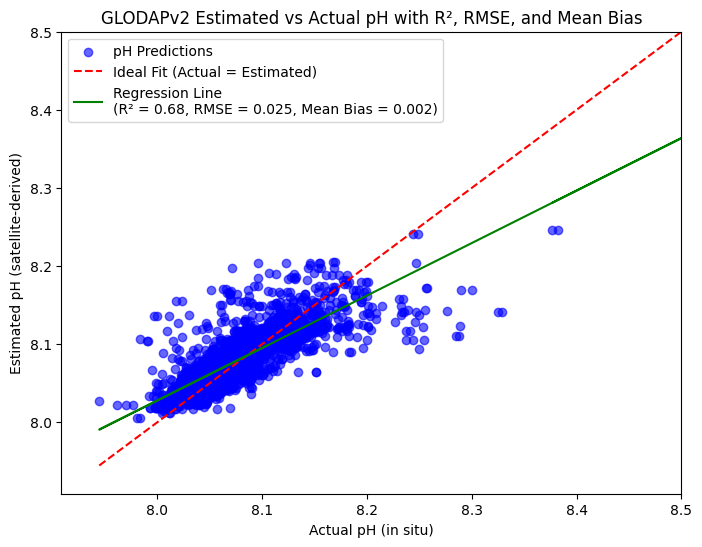

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='pH Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.3f}, Mean Bias = {mean_bias:.3f})')
plt.xlim(right=8.5)
plt.ylim(top=8.5)

# Labels and title
plt.xlabel('Actual pH (in situ)')
plt.ylabel('Estimated pH (satellite-derived)')
plt.title('GLODAPv2 Estimated vs Actual pH with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

In [ ]:
import pandas as pd
ARGOpH = pd.read_csv('/content/drive/MyDrive/STS/STSData/ph_cleaned.csv')

<ipython-input-76-1a7480bee586>:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  ARGOpH = pd.read_csv('/content/drive/MyDrive/STS/STSData/ph_cleaned.csv')


In [ ]:
ARGOpH = ARGOpH[ARGOpH['profile_ph_in_situ_total_qc'] == 'A']

In [ ]:
ARGOpH = ARGOpH[['ph_in_situ_total_adjusted', 'pres_adjusted', 'latitude', 'longitude', 'time']]
ARGOpH['time'] = pd.to_datetime(ARGOpH['time'], errors='coerce')

In [ ]:
ARGOpH['longitude'] = (ARGOpH['longitude'] + 360) % 360
ARGOpH['longitude'] = round((ARGOpH['longitude']) / 0.25) * 0.25 + 0.125
ARGOpH['latitude'] = round((ARGOpH['latitude']) / 0.25) * 0.25 + 0.125
ARGOpH['month'] = (ARGOpH['time'].dt.year - 2011) * 12 + ARGOpH['time'].dt.month - 9
ARGOpH=ARGOpH.dropna()

In [ ]:
ARGOpH = ARGOpH.loc[ARGOpH.groupby(['month', 'latitude', 'longitude'])['pres_adjusted'].idxmin()]

In [ ]:
ARGOpHMatchup = pd.merge(ARGOpH, satellite_data, on=['month', 'latitude', 'longitude'], how='inner')

In [ ]:
ARGOpHMatchup = ARGOpHMatchup.dropna()

In [ ]:
ARGOpHMatchup['clon'] = np.cos(np.deg2rad(ARGOpHMatchup['longitude']))
ARGOpHMatchup['slon'] = np.sin(np.deg2rad(ARGOpHMatchup['longitude']))
ARGOpHMatchup['windspeed'] = np.sqrt(ARGOpHMatchup['u_wind'] ** 2 + ARGOpHMatchup['v_wind'] ** 2)
ARGOpHMatchup['winddir'] = (np.degrees(np.arctan2(ARGOpHMatchup['u_wind'] + 1e-5, ARGOpHMatchup['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
X = ARGOpHMatchup[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y = ARGOpHMatchup['ph_in_situ_total_adjusted']

In [ ]:
evaluate_model(model, X, y)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


(0.0018849853982521843, -0.06287317714286011, 0.03168701919439108)

In [ ]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    0.1s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    0.1s finished


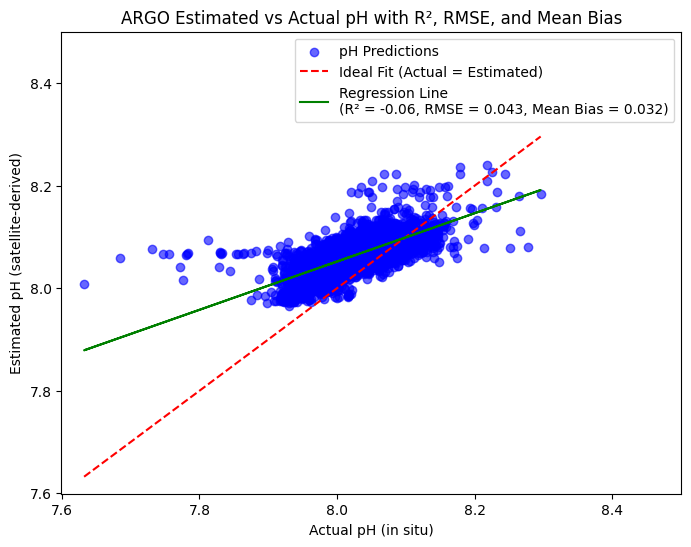

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Assuming y and y_pred are numpy arrays or lists
# Calculate R^2, RMSE, and Mean Bias
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))
mean_bias = np.mean(y_pred - y)

# Plotting y vs y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, label='pH Predictions', color='blue', alpha=0.6)
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Ideal Fit (Actual = Estimated)')

# Plot the linear regression line
m, b = np.polyfit(y, y_pred, 1)  # Fit line to y and y_pred
plt.plot(y, m * np.array(y) + b, color='green', label=f'Regression Line\n(R² = {r2:.2f}, RMSE = {rmse:.3f}, Mean Bias = {mean_bias:.3f})')
plt.xlim(right=8.5)
plt.ylim(top=8.5)

# Labels and title
plt.xlabel('Actual pH (in situ)')
plt.ylabel('Estimated pH (satellite-derived)')
plt.title('ARGO Estimated vs Actual pH with R², RMSE, and Mean Bias')
plt.legend()

# Show plot
plt.show()

## Basin Analysis

In [14]:
import netCDF4 as nc
import xarray as xr

# Open the NetCDF file using netCDF4
file_path = '/content/drive/MyDrive/STS/STSData/output_basins.nc'  # Replace with the path to your file
nc_dataset = nc.Dataset(file_path)

# Convert netCDF4.Dataset to xarray.Dataset
xr_dataset = xr.open_dataset(xr.backends.NetCDF4DataStore(nc_dataset))
basins = xr_dataset.to_dataframe().reset_index()

In [15]:
basins = basins.rename(columns={'lon' : 'longitude', 'lat' : 'latitude'})

In [16]:
X = test[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y = test[['ph', 'latitude', 'longitude']]

In [17]:
!pip install joblib

In [18]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ph.joblib')

In [19]:
y_pred = model.predict(X)

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.6s finished


In [20]:
y['predictions'] = y_pred

<ipython-input-20-e35c45553dfc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [21]:
from sklearn.metrics import mean_squared_error, r2_score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mean_bias = np.mean(y_pred - y_test)
    return mse, r2, mean_bias

In [22]:
def region_accuracy(rgn = -1):
  if rgn != -1:
    merged_df = pd.merge(y, basins, on=['latitude', 'longitude'])
    basin_data = merged_df[merged_df['open_ocean'] == rgn]
  else:
    basin_data = y
  rmse = np.sqrt(mean_squared_error(basin_data['ph'], basin_data['predictions']))
  r2 = r2_score(basin_data['ph'], basin_data['predictions'])
  mean_bias = np.mean(basin_data['predictions'] - basin_data['ph'])
  return rmse, r2, mean_bias, len(basin_data)

In [23]:
print("RMSE, R2, Bias, n")
print("Atlantic: ", region_accuracy(1))
print("Pacific: ", region_accuracy(2))
print("Indian: ", region_accuracy(3))
print("Arctic: ", region_accuracy(4))
print("Southern: ", region_accuracy(5))
print("Global: ", region_accuracy())

RMSE, R2, Bias, n
Atlantic:  (0.016505312921196925, 0.6900757804756852, 0.013160271761852943, 2213652)
Pacific:  (0.01756545696738225, 0.7492842251931007, 0.013917275261628698, 4768592)
Indian:  (0.014835292741604307, 0.6549840475457047, 0.01289313137867654, 1396298)
Arctic:  (0.026762948874669432, 0.7264163164944021, 0.013505727782118733, 156379)
Southern:  (0.01525835412403774, 0.5001510626666122, 0.012412521923259182, 2019811)
Global:  (0.01683008174625282, 0.7457989654091798, 0.01330936626898975, 10598925)


## Monthly Analysis

In [24]:
X = test[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y = test[['ph', 'month']]

In [ ]:
import joblib

model = joblib.load('/content/drive/MyDrive/STS/rf_ph.joblib')

KeyboardInterrupt: 

In [25]:
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:    3.6s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:    7.6s finished
<ipython-input-25-cdc18176f924>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['predictions'] = y_pred


In [26]:
def month_accuracy(mn):
  mn = (mn + 4) % 12
  month_data = y[y['month'] % 12 == mn]
  rmse = np.sqrt(mean_squared_error(month_data['ph'], month_data['predictions']))
  r2 = r2_score(month_data['ph'], month_data['predictions'])
  mean_bias = np.mean(month_data['predictions'] - month_data['ph'])
  return rmse, r2, mean_bias, len(month_data)

In [27]:
print("RMSE, R2, Bias, n")
print("January: ", month_accuracy(0))
print("February: ", month_accuracy(1))
print("March: ", month_accuracy(2))
print("April: ", month_accuracy(3))
print("May: ", month_accuracy(4))
print("June: ", month_accuracy(5))
print("July: ", month_accuracy(6))
print("August: ", month_accuracy(7))
print("September: ", month_accuracy(8))
print("October: ", month_accuracy(9))
print("November: ", month_accuracy(10))
print("December: ", month_accuracy(11))

RMSE, R2, Bias, n
January:  (0.01562773529845332, 0.7258803581950729, 0.012532950968511973, 953842)
February:  (0.015827388250025942, 0.7564888069200758, 0.013171294113702516, 974285)
March:  (0.016248828603810127, 0.729343780118952, 0.013639968786809703, 979134)
April:  (0.017924058993703737, 0.670459050575662, 0.013670703561579768, 814897)
May:  (0.018074267256861374, 0.7574286163332982, 0.012779158469005535, 804883)
June:  (0.018007264041215252, 0.8176912433775778, 0.01201214299116124, 756954)
July:  (0.0167206977986683, 0.8462069428582384, 0.012372541401955395, 787782)
August:  (0.017290630276641076, 0.8002049698845649, 0.014382680132767835, 868005)
September:  (0.016824567626970256, 0.7373934202957276, 0.013742410664471832, 915887)
October:  (0.016040431090211475, 0.6519140108543682, 0.012943844178993863, 935118)
November:  (0.0161773356684368, 0.5734563031170528, 0.013447774408157588, 905683)
December:  (0.017608129017537555, 0.6013550275192447, 0.014740839890438664, 902455)


In [ ]:
satellite_data = pd.read_csv('/content/drive/MyDrive/STS/STSData/combined_satellite_X.nc')

In [ ]:
satellite_data['mn'] = satellite_data['month'] % 12
satellite_data['cmon'] = np.cos(np.deg2rad(satellite_data['mn']))
satellite_data['smon'] = np.sin(np.deg2rad(satellite_data['mn']))
satellite_data['clon'] = np.cos(np.deg2rad(satellite_data['longitude']))
satellite_data['slon'] = np.sin(np.deg2rad(satellite_data['longitude']))
satellite_data['pic/poc'] = satellite_data['pic']/satellite_data['poc']
satellite_data['logchla'] = np.log(satellite_data['chlor_a'] + 1e-5)
satellite_data['windspeed'] = np.sqrt(satellite_data['u_wind'] ** 2 + satellite_data['v_wind'] ** 2)
satellite_data['winddir'] = (np.degrees(np.arctan2(satellite_data['u_wind'] + 1e-5, satellite_data['u_wind'] + 1e-5)) + 360) % 360

In [ ]:
y = satellite_data[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a', 'month', 'longitude']]
y = y.dropna()
X = y[['latitude', 'sst', 'sss', 'clon', 'slon', 'windspeed', 'winddir', 'chlor_a']]
y_pred = model.predict(X)
y['predictions'] = y_pred

[Parallel(n_jobs=67)]: Using backend ThreadingBackend with 67 concurrent workers.
[Parallel(n_jobs=67)]: Done  66 tasks      | elapsed:   20.9s
[Parallel(n_jobs=67)]: Done 200 out of 200 | elapsed:   42.0s finished


In [ ]:
import xarray as xr
import numpy as np

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

ph = ds['ph_total']

# Select the specific variable 'ph' and time indices from 361 to 480
ph_subset = ph.isel(time=slice(360, 480))  # Python uses zero-based indexing

# Compute the monthly climatology over the selected 10 years
monthly_climatology = ph_subset.groupby('time.month').mean(dim='time')

monthly_climatology = monthly_climatology.assign_coords(
    lon=((monthly_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
monthly_climatology = monthly_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the monthly climatologies onto the new grid
interp_ph = monthly_climatology.interp(lat=new_lat, lon=new_lon, method='linear')

In [ ]:
ten_year = y[(y['month'] >= 4) & (y['month'] <= 123)]

In [ ]:
def month_clim(mn = -1):
  if(mn != -1):
    mn = (mn + 4) % 12
    month_data = ten_year[ten_year['month'] % 12 == mn]
  else:
    month_data = ten_year
  month_data = month_data.dropna()
  monthly_climatology = month_data.groupby(['latitude', 'longitude'])['predictions'].mean().reset_index()
  return monthly_climatology

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score

# Assuming 'interp_ph' is your observed climatology DataArray from previous steps
# And 'month_clim' is your function that returns predicted climatology for a given month

# Initialize lists to store metrics for each month
r2_list = []
rmse_list = []
mean_bias_list = []
n_list = []

for i in range(12):
    # **1. Get Predicted Climatology for Month i**
    # Call your function 'month_clim' to get the predicted climatology for month i
    pred_clim = month_clim(i)  # Should return a pandas DataFrame

    # Ensure 'pred_clim' has columns 'lat', 'lon', 'ph_pred'
    if 'predictions' in pred_clim.columns:
        pred_clim = pred_clim.rename(columns={'predictions': 'ph_pred'})


    # **3. Get Observed Climatology for Month i+1**
    # 'interp_ph' uses months from 1 to 12
    observed_clim = interp_ph.sel(month=i+1)

    # Convert the observed DataArray to a DataFrame
    observed_clim_df = observed_clim.to_dataframe(name='ph_obs').reset_index().dropna()
    observed_clim_df = observed_clim_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
    observed_clim_df['longitude'] = (observed_clim_df['longitude'] + 360) % 360

    # **4. Merge Predicted and Observed DataFrames on 'lat' and 'lon'**
    merged_df = pd.merge(pred_clim, observed_clim_df, on=['latitude', 'longitude'])

    merged_df = merged_df.dropna()
    # **5. Compute Metrics**
    # R² Score
    r2 = r2_score(merged_df['ph_obs'], merged_df['ph_pred'])

    # Root Mean Squared Error (rmse)
    rmse = np.sqrt(mean_squared_error(merged_df['ph_obs'], merged_df['ph_pred']))

    # Mean Bias (Mean of Differences)
    mean_bias = np.mean(merged_df['ph_pred'] - merged_df['ph_obs'])

    n = len(merged_df)

    # print(r2, rmse, mean_bias, n)
    # **6. Store Metrics**
    r2_list.append(r2)
    rmse_list.append(rmse)
    mean_bias_list.append(mean_bias)
    n_list.append(n)

# **7. Compile Results into a DataFrame**
metrics_df = pd.DataFrame({
    'Month': range(1, 13),
    'R²': r2_list,
    'rmse': rmse_list,
    'Mean Bias': mean_bias_list,
    'n': n_list
})

# **8. Display the Results**
print(metrics_df)

    Month        R²      rmse  Mean Bias       n
0       1  0.768312  0.015460  -0.004521  511293
1       2  0.783530  0.015059  -0.003878  528406
2       3  0.778065  0.013312  -0.003407  529708
3       4  0.799853  0.012028  -0.002420  490570
4       5  0.882647  0.012274  -0.000661  434690
5       6  0.893755  0.013726   0.000818  412799
6       7  0.869791  0.015679   0.000959  436779
7       8  0.852580  0.015419  -0.001591  485251
8       9  0.817216  0.014007  -0.002333  507282
9      10  0.742347  0.013134  -0.002839  487720
10     11  0.755040  0.011950  -0.002906  476658
11     12  0.740241  0.014177  -0.003003  488289


In [ ]:
import xarray as xr
import numpy as np
import pandas as pd

# Open the dataset
ds = xr.open_dataset('/content/drive/MyDrive/STS/STSData/OceanSODA_ETHZ-v2023.OCADS.01_1982-2022.nc')

# Select the specific variable 'ph' and time indices from 361 to 480
ph_subset = ds['ph_total'].isel(time=slice(360, 480))  # Zero-based indexing

# Compute the full climatology over the selected 10-year period
full_climatology = ph_subset.mean(dim='time')

full_climatology = full_climatology.assign_coords(
    lon=((full_climatology.lon + 360) % 360)
)

# Sort longitudes to ensure proper order
full_climatology = full_climatology.sortby('lon')

# Define the new high-resolution grid
new_lon = np.arange(0.125, 360, 0.25)
new_lat = np.arange(-89.875, 90, 0.25)

# Interpolate the full climatology onto the new grid
interp_full_climatology = full_climatology.interp(lat=new_lat, lon=new_lon)

# Convert to DataFrame
full_climatology_df = interp_full_climatology.to_dataframe(name='ph_obs').reset_index().dropna()
full_climatology_df = full_climatology_df.rename(columns={'lat': 'latitude', 'lon': 'longitude'})
# full_climatology_df['longitude'] = (full_climatology_df['longitude'] + 360) % 360

In [ ]:
full_climatology_df.max()

,0
latitude,85.375000
longitude,359.375000
ph_obs,8.223638


In [ ]:
pred_clim = month_clim()
merged_df = pd.merge(pred_clim, full_climatology_df, on=['latitude', 'longitude']).dropna()
merged_df['pH Differences With GRaCER'] = merged_df['predictions'] - merged_df['ph_obs']

In [ ]:
ds = merged_df.set_index(['latitude', 'longitude']).to_xarray()
ds.to_netcdf('climatological_diff.nc')

In [ ]:
merged_df.min()

,0
latitude,-74.375000
longitude,0.625000
predictions,7.959876
ph_obs,7.913182
pH Differences With GRaCER,-0.184324
